In [27]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [28]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [29]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [30]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [31]:
tf.keras.backend.clear_session()

In [32]:
subject = 'Paraná - Consumo de Cimento (t)'
start_index = 0
split_index = 179
window_size = 36
train_split = split_index + 1 - 12

In [33]:
data = pd.read_csv('2003_mo_model_input_PR.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Paraná - Desemprego,Paraná - value,Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Paraná - PIB - Preços de Mercado,Paraná - IDH,Paraná - Consumo de Cimento (t)
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.284196,0.300568,332.705560,2.027147e+08,1.060612e+07,17.589536,1.851788e+08,0.776871,189.804
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.277973,0.301710,332.945945,2.029477e+08,1.061597e+07,17.592548,1.852326e+08,0.776975,174.713
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.271750,0.302645,335.222130,2.031806e+08,1.062582e+07,17.595559,1.852864e+08,0.777079,180.801
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.265527,0.303413,334.785737,2.034136e+08,1.063567e+07,17.598570,1.853401e+08,0.777183,180.172
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.259304,0.304034,335.050185,2.036466e+08,1.064551e+07,17.601581,1.853939e+08,0.777287,185.597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.549782,616.073841,NaN,NaN,NaN,NaN,NaN,412.177
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.546864,614.423079,NaN,NaN,NaN,NaN,NaN,337.056
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.544541,613.772150,NaN,NaN,NaN,NaN,NaN,340.018
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.540629,614.761140,NaN,NaN,NaN,NaN,NaN,383.477


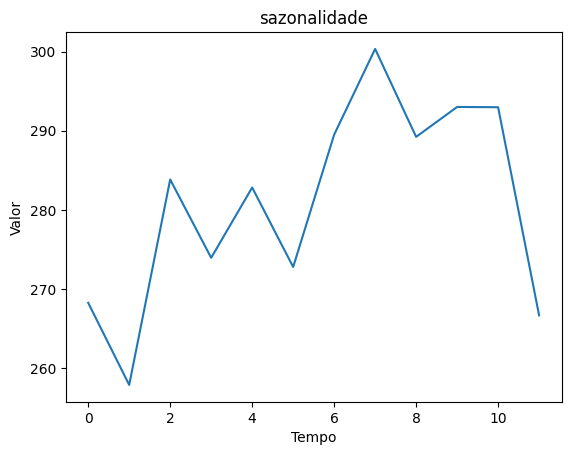

,sazonalidade
sazonalidade,
0,268.268214
1,257.896429
2,283.840571
3,273.950571
4,282.830429
5,272.791286
6,289.501500
7,300.332143
8,289.225643


In [34]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [35]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Paraná - Desemprego,Paraná - value,Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - PIB - Per Capita,Paraná - PIB - Preços de Mercado,Paraná - IDH,sazonalidade,Paraná - Consumo de Cimento (t)
0,2003-1,0.724032,-5331.049150,11.520143,1.639718,1.036534,1.772069e+08,7.330309e+06,0.969649,8.284196,0.300568,332.705560,2.027147e+08,1.060612e+07,17.589536,1.851788e+08,0.776871,268.268214,189.804
1,2003-2,0.690297,-5318.079644,11.189862,1.378899,0.993449,1.773884e+08,7.335910e+06,0.950783,8.277973,0.301710,332.945945,2.029477e+08,1.061597e+07,17.592548,1.852326e+08,0.776975,257.896429,174.713
2,2003-3,0.669681,-5436.417870,10.820792,1.924317,0.973020,1.775699e+08,7.341511e+06,0.938332,8.271750,0.302645,335.222130,2.031806e+08,1.062582e+07,17.595559,1.852864e+08,0.777079,283.840571,180.801
3,2003-4,0.660494,-5707.015274,10.417840,1.331174,0.940489,1.777514e+08,7.347112e+06,0.926401,8.265527,0.303413,334.785737,2.034136e+08,1.063567e+07,17.598570,1.853401e+08,0.777183,273.950571,180.172
4,2003-5,0.648337,-5599.317941,9.959690,1.736072,0.917493,1.779329e+08,7.352713e+06,0.951683,8.259304,0.304034,335.050185,2.036466e+08,1.064551e+07,17.601581,1.853939e+08,0.777287,282.830429,185.597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.549782,616.073841,NaN,NaN,NaN,NaN,NaN,300.332143,412.177
236,2022-9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.546864,614.423079,NaN,NaN,NaN,NaN,NaN,289.225643,337.056
237,2022-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.544541,613.772150,NaN,NaN,NaN,NaN,NaN,293.003214,340.018
238,2022-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.540629,614.761140,NaN,NaN,NaN,NaN,NaN,292.969214,383.477


In [36]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      172.044
1      188.841
2      200.253
3      188.916
4      184.994
        ...   
235        NaN
236        NaN
237        NaN
238        NaN
239        NaN
Name: Paraná - Consumo de Cimento (t), Length: 240, dtype: float64

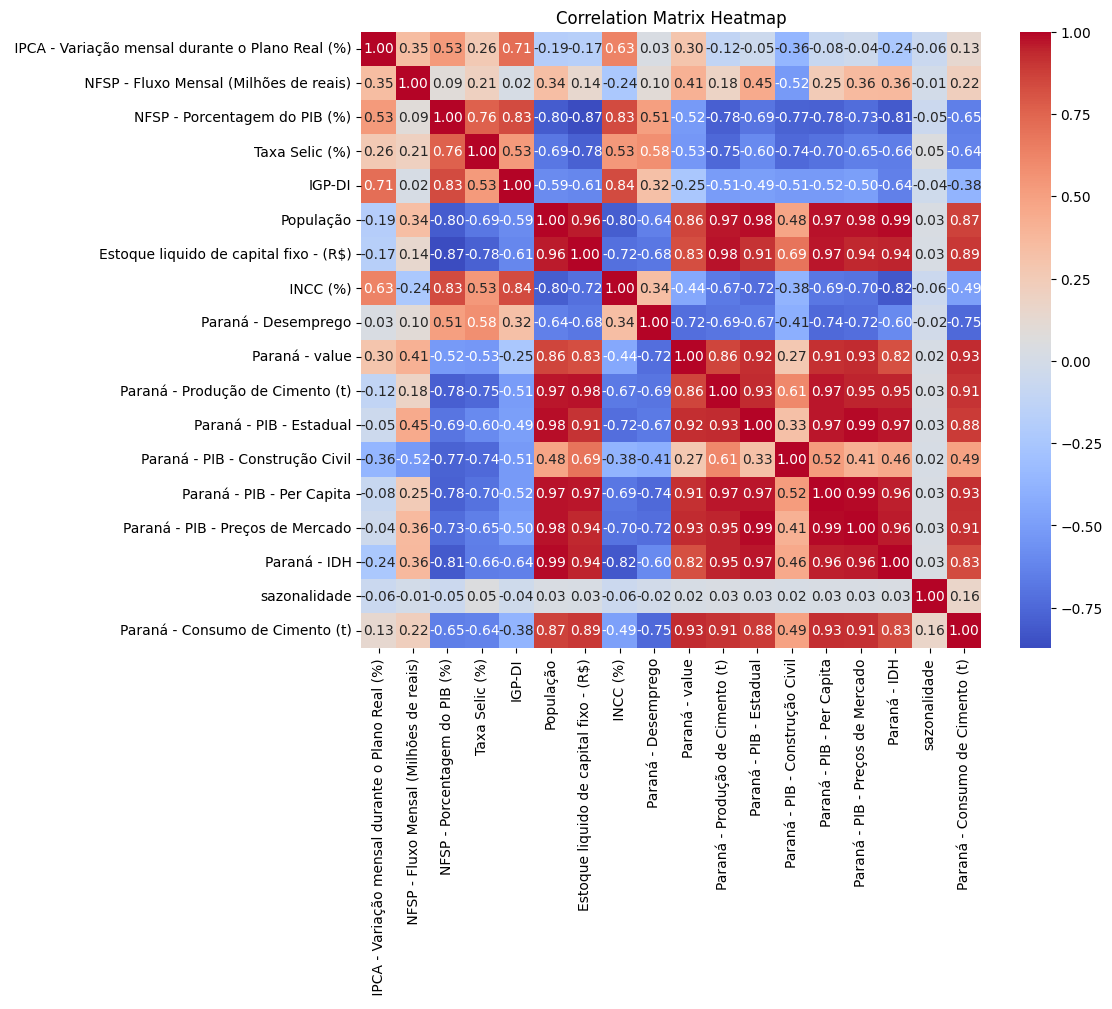

In [37]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [38]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [39]:
safe_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,IPCA - Variação mensal durante o Plano Real (%),2.689806e+03
1,NFSP - Fluxo Mensal (Milhões de reais),2.651731e+02
2,NFSP - Porcentagem do PIB (%),2.831957e+02
3,Taxa Selic (%),5.928536e+01
4,IGP-DI,3.594774e+02
5,População,1.731758e+06
6,Estoque liquido de capital fixo - (R$),1.984272e+07
7,INCC (%),1.817236e+03
8,Paraná - Desemprego,2.858581e+03
9,Paraná - value,8.874210e+03


In [40]:
data = remove_high_vif_columns(safe_data, 1000000)
data

Num columns removed: 4


,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,INCC (%),Paraná - Desemprego,Paraná - value,Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - IDH,sazonalidade
0,0.724032,-5331.049150,11.520143,1.639718,1.036534,0.969649,8.284196,0.300568,332.705560,2.027147e+08,1.060612e+07,0.776871,268.268214
1,0.690297,-5318.079644,11.189862,1.378899,0.993449,0.950783,8.277973,0.301710,332.945945,2.029477e+08,1.061597e+07,0.776975,257.896429
2,0.669681,-5436.417870,10.820792,1.924317,0.973020,0.938332,8.271750,0.302645,335.222130,2.031806e+08,1.062582e+07,0.777079,283.840571
3,0.660494,-5707.015274,10.417840,1.331174,0.940489,0.926401,8.265527,0.303413,334.785737,2.034136e+08,1.063567e+07,0.777183,273.950571
4,0.648337,-5599.317941,9.959690,1.736072,0.917493,0.951683,8.259304,0.304034,335.050185,2.036466e+08,1.064551e+07,0.777287,282.830429
...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,0.366904,-5783.316460,2.206994,0.545067,0.471521,0.378150,7.487170,0.400855,493.627481,2.425332e+08,1.097704e+07,0.787082,300.332143
176,0.358935,-6001.730740,2.215328,0.782910,0.476827,0.377666,7.477752,0.401377,493.374474,2.424937e+08,1.097741e+07,0.787011,289.225643
177,0.354313,-6454.887704,2.232466,0.909682,0.475427,0.377838,7.468333,0.401647,494.637705,2.424541e+08,1.097778e+07,0.786939,293.003214
178,0.352728,-6243.191421,2.263185,1.050614,0.491301,0.370057,7.458915,0.402140,495.875938,2.424146e+08,1.097816e+07,0.786868,292.969214


In [41]:
input_data = data.fillna(0.0).iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
input_data = input_data.fillna(0.0)
input_data

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,INCC (%),Paraná - Desemprego,Paraná - value,Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - IDH
0,0.604311,4.268118,2.039314,3.921218,3.214079,1.135376,-0.928691,-1.637316,-1.606120,-2.340956,-2.091701
1,0.609431,4.096014,1.195209,3.582946,3.051841,1.121280,-0.910659,-1.633307,-1.589113,-2.294567,-2.058133
2,0.562720,3.903698,2.960381,3.422548,2.944772,1.107184,-0.895896,-1.595339,-1.572106,-2.248179,-2.024564
3,0.455907,3.693727,1.040752,3.167136,2.842174,1.093087,-0.883769,-1.602618,-1.555099,-2.201790,-1.990995
4,0.498418,3.454992,2.351150,2.986591,3.059587,1.078991,-0.873955,-1.598207,-1.538092,-2.155401,-1.957426
...,...,...,...,...,...,...,...,...,...,...,...
175,0.425789,-0.584804,-1.503380,-0.514871,-1.872446,-0.670068,0.655022,1.046917,1.300715,-0.593728,1.207515
176,0.339575,-0.580461,-0.733634,-0.473208,-1.876611,-0.691403,0.663269,1.042697,1.297829,-0.591970,1.184461
177,0.160702,-0.571531,-0.323353,-0.484199,-1.875135,-0.712739,0.667524,1.063768,1.294942,-0.590212,1.161407
178,0.244264,-0.555524,0.132757,-0.359568,-1.942040,-0.734074,0.675307,1.084422,1.292056,-0.588453,1.138352


In [42]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,INCC (%),Paraná - Desemprego,Paraná - value,Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - IDH
0,0.604311,4.268118,2.039314,3.921218,3.214079,1.135376,-0.928691,-1.637316,-1.606120,-2.340956,-2.091701
1,0.609431,4.096014,1.195209,3.582946,3.051841,1.121280,-0.910659,-1.633307,-1.589113,-2.294567,-2.058133
2,0.562720,3.903698,2.960381,3.422548,2.944772,1.107184,-0.895896,-1.595339,-1.572106,-2.248179,-2.024564
3,0.455907,3.693727,1.040752,3.167136,2.842174,1.093087,-0.883769,-1.602618,-1.555099,-2.201790,-1.990995
4,0.498418,3.454992,2.351150,2.986591,3.059587,1.078991,-0.873955,-1.598207,-1.538092,-2.155401,-1.957426
...,...,...,...,...,...,...,...,...,...,...,...
163,1.465326,-0.676734,0.472779,-1.087000,-1.491033,-0.249301,0.595872,0.882861,1.309485,-0.529993,1.474560
164,1.351131,-0.668750,0.302784,-0.904679,-1.525186,-0.303585,0.581998,0.897453,1.311772,-0.545202,1.453427
165,1.143146,-0.657609,0.339539,-0.900134,-1.546744,-0.357869,0.572513,0.913574,1.314059,-0.560410,1.432294
166,1.542609,-0.647588,0.472795,-1.136836,-1.586381,-0.412153,0.564328,0.928670,1.316346,-0.575619,1.411161


In [43]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      172.044
1      188.841
2      200.253
3      188.916
4      184.994
        ...   
163    344.937
164    302.082
165    294.467
166    336.029
167    278.117
Name: Paraná - Consumo de Cimento (t), Length: 168, dtype: float64

In [44]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [45]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 11)

In [46]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,INCC (%),Paraná - Desemprego,Paraná - value,Paraná - Produção de Cimento (t),Paraná - PIB - Estadual,Paraná - PIB - Construção Civil,Paraná - IDH
132,0.817451,-0.366715,-0.530011,0.174628,-0.066954,-0.726081,1.580396,0.875957,1.017465,0.234366,0.762919
133,1.130195,-0.350285,-0.532694,0.240832,-0.130652,-0.659857,1.592156,0.888756,1.031809,0.204543,0.757772
134,1.160498,-0.335122,-0.186421,0.176857,-0.079602,-0.593634,1.599280,0.883920,1.046154,0.174720,0.752625
135,1.131990,-0.321950,-0.719664,-0.005233,-0.034473,-0.527410,1.604093,0.878665,1.060499,0.144897,0.747478
136,1.384387,-0.302995,-0.798520,0.097576,-0.177535,-0.461187,1.607510,0.873061,1.074843,0.115074,0.742331
137,1.375487,-0.290554,-0.612129,0.431487,-0.208868,-0.394963,1.610217,0.866861,1.089188,0.085251,0.737184
138,1.438928,-0.281926,-0.476740,0.482414,-0.245300,-0.328740,1.603503,0.860358,1.103533,0.055428,0.732037
139,1.569590,-0.275931,-0.211736,0.657043,-0.333490,-0.262516,1.591542,0.853300,1.117877,0.025605,0.726890
140,1.584058,-0.271466,-0.484608,0.678386,-0.296846,-0.196292,1.574229,0.845929,1.132222,-0.004218,0.721743
141,1.166380,-0.273241,-0.183907,0.727143,-0.292462,-0.130069,1.554681,0.838255,1.146567,-0.034041,0.716596


In [47]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 11)

In [48]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
    # Método estocástico e learning rate=0.005
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(72, activation='tanh', 
                            return_sequences=True, 
                            kernel_regularizer=tf.keras.regularizers.l2(0.01),  
                            input_shape=(reshaped_train.shape[1], reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(36, activation='tanh', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=optimizer,
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
                        validation_split=0.14,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [49]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [50]:
def predictor(model, test_input, test_target, start_target):
    
    predictions = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        if (prediction[0][0] < 0.0):
            return None, None, None
        predictions.append(prediction[0][0])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    mape = np.mean(df_results["Error"])/np.mean(df_results["Target"])

    return df_results, predictions, mape

In [51]:
def statistical_validator(train_input, train_target, test_input, test_target, start_target):
    
    pd.set_option('display.max_columns', None)
    predictions_list = []
    error_percent = []
    
    i = 0
    while i < 10:
        winner_seed = get_a_good_seed(train_input, train_target, test_input, test_target)
        trained_model, history = lstm_model(train_input, 
                                            train_target, 
                                            want_verbose=0, 
                                            seed=winner_seed)
        df_results, predictions, mape = predictor(trained_model, 
                                            test_input, 
                                            test_target, 
                                            start_index)
        if predictions is not None:
            display(f"\n\Results: {i} ___________________________________________\n")
            display(df_results.T)
            display(mape)
            predictions_list.append(predictions)
            i += 1
        
    predictions_means = np.mean(predictions_list, axis=0)
    results_data = []
   
    for j in range(12):
        target = test_target[start_target + j]
        error = np.abs(predictions_means[j] - target)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                            predictions_means[j], 
                            target, 
                            error])
    display("FINAL___________________________________________________________________")
    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])
    display(df_results.T)
        
    mae_mean = np.mean(predictions_means)
    mape_mean = np.mean(error_percent) 

    return mae_mean, mape_mean

In [52]:
mae, mape = statistical_validator(reshaped_train, 
                                  reshaped_target, 
                                  reshaped_test, 
                                  reshaped_test_target, 
                                  start_index)

[2416620811, 1820092276, 2891797497, 610294085, 862040114, 2170619264, 1909247892, 891726795, 2726469583, 1865905260]


Step: 0 ___________________________________________
val_loss: 1452.5091552734375
winner_seed: 2416620811


Step: 1 ___________________________________________
val_loss: 6282810880.0


Step: 2 ___________________________________________
val_loss: 1159.039306640625
winner_seed: 2891797497


Step: 3 ___________________________________________
val_loss: 1155.289306640625
winner_seed: 610294085


Step: 4 ___________________________________________
val_loss: 1252.2198486328125


Step: 5 ___________________________________________
val_loss: 1493.3272705078125


Step: 6 ___________________________________________
val_loss: 1236.35693359375


Step: 7 ___________________________________________
val_loss: 1755.98583984375


Step: 8 ___________________________________________
val_loss: 388340.46875


Step: 9 ___________________________________________
val_loss: 1335.7657470703125

'\n\\Results: 0 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,315.86084,336.746429,314.053253,315.374268,316.08551,323.743835,311.739136,349.981171,336.531006,314.80365,315.33728,314.802155
Target,323.005,291.453,300.203,317.058,314.142,301.878,358.797,356.169,316.188,346.214,323.401,238.466
Error,7.144165,45.293427,13.85025,1.683746,1.943512,21.865845,47.057861,6.187836,20.343018,31.410339,8.063721,76.336151


0.07424922130584174

[69137780, 2118680830, 2825946859, 2004780958, 1899355475, 1873990953, 2754410452, 2192955559, 657438389, 3881399530]


Step: 0 ___________________________________________
val_loss: 1122.1650390625
winner_seed: 69137780


Step: 1 ___________________________________________
val_loss: 1151.6253662109375


Step: 2 ___________________________________________
val_loss: 35503869001728.0


Step: 3 ___________________________________________
val_loss: 1123.6431884765625


Step: 4 ___________________________________________
val_loss: 1045.794677734375
winner_seed: 1899355475


Step: 5 ___________________________________________
val_loss: 130982040.0


Step: 6 ___________________________________________
val_loss: 1195.5323486328125


Step: 7 ___________________________________________
val_loss: 1208.9814453125


Step: 8 ___________________________________________
val_loss: 7335170048.0


Step: 9 ___________________________________________
val_loss: 9422.681640625
1/1 [===========================

'\n\\Results: 1 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,321.776886,325.37677,324.081879,334.982941,336.274811,330.646698,333.566132,325.976227,330.806793,328.994568,322.579773,307.16922
Target,323.005,291.453,300.203,317.058,314.142,301.878,358.797,356.169,316.188,346.214,323.401,238.466
Error,1.228119,33.923767,23.878876,17.924927,22.132812,28.768707,25.230865,30.19278,14.618805,17.219421,0.821228,68.703217


0.07516384230272702

[4035472692, 2085066585, 2298034754, 1825347972, 1624841661, 4027637876, 4059676832, 104737272, 3938514448, 2296698007]


Step: 0 ___________________________________________
val_loss: 1645.369140625
winner_seed: 4035472692


Step: 1 ___________________________________________
val_loss: 1482.627685546875
winner_seed: 2085066585


Step: 2 ___________________________________________
val_loss: 9807671296.0


Step: 3 ___________________________________________
val_loss: 2.061363197163602e+17


Step: 4 ___________________________________________
val_loss: 1155.2410888671875
winner_seed: 1624841661


Step: 5 ___________________________________________
val_loss: 1201.763671875


Step: 6 ___________________________________________
val_loss: 1239.677978515625


Step: 7 ___________________________________________
val_loss: 1325.298828125


Step: 8 ___________________________________________
val_loss: 1383.7955322265625


Step: 9 ___________________________________________
val_loss: 1203.344726562

'\n\\Results: 2 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,317.349457,337.463959,329.761261,322.932526,331.948334,337.603149,316.021179,366.680939,347.162384,342.408234,361.12439,354.667908
Target,323.005,291.453,300.203,317.058,314.142,301.878,358.797,356.169,316.188,346.214,323.401,238.466
Error,5.655548,46.010956,29.558258,5.874512,17.806335,35.725159,42.775818,10.511932,30.974396,3.805756,37.723389,116.201904


0.10103686014277989

[281617859, 603995850, 3470764335, 343087274, 2999113435, 3398720086, 2232447545, 3649161030, 1883016299, 3043060094]


Step: 0 ___________________________________________
val_loss: 1151.8736572265625
winner_seed: 281617859


Step: 1 ___________________________________________
val_loss: 1268.743896484375


Step: 2 ___________________________________________
val_loss: 1264.8692626953125


Step: 3 ___________________________________________
val_loss: 1249.7471923828125


Step: 4 ___________________________________________
val_loss: 1145.19482421875
winner_seed: 2999113435


Step: 5 ___________________________________________
val_loss: 1198.2529296875


Step: 6 ___________________________________________
val_loss: 1653372.75


Step: 7 ___________________________________________
val_loss: 1412.2742919921875


Step: 8 ___________________________________________
val_loss: 1283.024658203125


Step: 9 ___________________________________________
val_loss: 785271029760.0
1/1 [===================

'\n\\Results: 3 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,309.810211,316.679474,319.667206,319.176178,322.90213,325.139984,300.439789,325.486877,330.091949,325.161285,319.53476,319.345306
Target,323.005,291.453,300.203,317.058,314.142,301.878,358.797,356.169,316.188,346.214,323.401,238.466
Error,13.194794,25.226471,19.464203,2.118164,8.760132,23.261993,58.357208,30.682129,13.903961,21.052704,3.866241,80.879303


0.07942153906174082

[2451256338, 247144674, 1637473490, 2229340981, 875329719, 3900577093, 2430936912, 2768340215, 3143995338, 73140969]


Step: 0 ___________________________________________
val_loss: 1362.762939453125
winner_seed: 2451256338


Step: 1 ___________________________________________
val_loss: 1250.065673828125
winner_seed: 247144674


Step: 2 ___________________________________________
val_loss: 1434.5208740234375


Step: 3 ___________________________________________
val_loss: 1271.5623779296875


Step: 4 ___________________________________________
val_loss: 1272.9808349609375


Step: 5 ___________________________________________
val_loss: 1305.415771484375


Step: 6 ___________________________________________
val_loss: 1125.2108154296875
winner_seed: 2430936912


Step: 7 ___________________________________________
val_loss: 1179.697509765625


Step: 8 ___________________________________________
val_loss: 1172.8231201171875


Step: 9 ___________________________________________
val_loss: 1234.

'\n\\Results: 4 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,312.2052,323.19635,337.167969,321.630798,327.263,327.452911,318.136292,365.366302,342.104553,345.015808,341.593109,333.625
Target,323.005,291.453,300.203,317.058,314.142,301.878,358.797,356.169,316.188,346.214,323.401,238.466
Error,10.799805,31.743347,36.964966,4.572784,13.121002,25.574921,40.660706,9.197296,25.916565,1.198181,18.192108,95.158997


0.08267832571885624

[1657150095, 1516963796, 3720284487, 4153408604, 3059403273, 1621063192, 2299401631, 2962131353, 2534086816, 1118647508]


Step: 0 ___________________________________________
val_loss: 1133.5230712890625
winner_seed: 1657150095


Step: 1 ___________________________________________
val_loss: 1384.021484375


Step: 2 ___________________________________________
val_loss: 1215.0733642578125


Step: 3 ___________________________________________
val_loss: 1342.19091796875


Step: 4 ___________________________________________
val_loss: 1442.34033203125


Step: 5 ___________________________________________
val_loss: 2.1075408974494092e+20


Step: 6 ___________________________________________
val_loss: 1426.0594482421875


Step: 7 ___________________________________________
val_loss: 1409.1669921875


Step: 8 ___________________________________________
val_loss: 1795.1480712890625


Step: 9 ___________________________________________
val_loss: 1168.7271728515625
1/1 [===========================

'\n\\Results: 5 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,314.172363,331.158997,331.361328,332.688477,339.906433,348.889252,336.278717,367.70813,363.50824,345.645416,353.310822,351.314087
Target,323.005,291.453,300.203,317.058,314.142,301.878,358.797,356.169,316.188,346.214,323.401,238.466
Error,8.832642,39.705994,31.158325,15.630463,25.764435,47.011261,22.51828,11.539124,47.320251,0.568573,29.909821,112.848083


0.10372588660967132

[7786414, 2830443938, 3867593063, 1428254610, 3691370607, 885004425, 897769236, 706863442, 3612676127, 4077121074]


Step: 0 ___________________________________________
val_loss: 1120.478759765625
winner_seed: 7786414


Step: 1 ___________________________________________
val_loss: 1772.7598876953125


Step: 2 ___________________________________________
val_loss: 1229.593505859375


Step: 3 ___________________________________________
val_loss: 1381.998046875


Step: 4 ___________________________________________
val_loss: 1116.3372802734375
winner_seed: 3691370607


Step: 5 ___________________________________________
val_loss: 1130.9281005859375


Step: 6 ___________________________________________
val_loss: 1600.294189453125


Step: 7 ___________________________________________
val_loss: 1389.602294921875


Step: 8 ___________________________________________
val_loss: 1085.037841796875
winner_seed: 3612676127


Step: 9 ___________________________________________
val_loss: 1167.723754882

'\n\\Results: 6 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,314.734161,292.015564,270.447144,299.53717,277.421173,266.774323,262.064056,263.207031,265.067078,261.924377,266.114349,260.062805
Target,323.005,291.453,300.203,317.058,314.142,301.878,358.797,356.169,316.188,346.214,323.401,238.466
Error,8.270844,0.562561,29.755859,17.520844,36.720825,35.103668,96.732941,92.961975,51.120911,84.289612,57.286652,21.596802


0.14046134107476668

[1230516346, 1783289063, 1942471924, 2780155172, 4158285597, 2780108233, 3010180312, 1657076814, 529023516, 3704192718]


Step: 0 ___________________________________________
val_loss: 961.541748046875
winner_seed: 1230516346


Step: 1 ___________________________________________
val_loss: 1270.4337158203125


Step: 2 ___________________________________________
val_loss: 1152.22705078125


Step: 3 ___________________________________________
val_loss: 1499.232421875


Step: 4 ___________________________________________
val_loss: 3306177691648.0


Step: 5 ___________________________________________
val_loss: 1089.101318359375


Step: 6 ___________________________________________
val_loss: 2728.719970703125


Step: 7 ___________________________________________
val_loss: 1159.910400390625


Step: 8 ___________________________________________
val_loss: 1446.9525146484375


Step: 9 ___________________________________________
val_loss: 1188.965576171875
1/1 [==============================] - 0s

'\n\\Results: 7 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,304.079132,309.830963,320.752441,317.849426,312.862396,318.454529,304.398438,316.920166,323.713776,323.146973,331.424408,320.092865
Target,323.005,291.453,300.203,317.058,314.142,301.878,358.797,356.169,316.188,346.214,323.401,238.466
Error,18.925873,18.37796,20.549438,0.791412,1.279602,16.576538,54.39856,39.24884,7.525787,23.067017,8.023407,81.626862


0.07668161670962732

[763058829, 1402591821, 1182691692, 1077210792, 4291007779, 291770155, 4180033898, 295853915, 122232964, 1642189161]


Step: 0 ___________________________________________
val_loss: 1393.759521484375
winner_seed: 763058829


Step: 1 ___________________________________________
val_loss: 1338.8988037109375
winner_seed: 1402591821


Step: 2 ___________________________________________
val_loss: 1219.2686767578125
winner_seed: 1182691692


Step: 3 ___________________________________________
val_loss: 1190.0528564453125
winner_seed: 1077210792


Step: 4 ___________________________________________
val_loss: 2298.701416015625


Step: 5 ___________________________________________
val_loss: 7836225024.0


Step: 6 ___________________________________________
val_loss: 1471.7979736328125


Step: 7 ___________________________________________
val_loss: 1135.325927734375
winner_seed: 295853915


Step: 8 ___________________________________________
val_loss: 1617.31494140625


Step: 9 ___________________

'\n\\Results: 8 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,314.503937,323.78183,317.684967,317.710693,324.765564,324.23111,314.441254,331.264832,336.254456,329.521027,327.652252,320.580261
Target,323.005,291.453,300.203,317.058,314.142,301.878,358.797,356.169,316.188,346.214,323.401,238.466
Error,8.501068,32.328827,17.481964,0.652679,10.623566,22.353119,44.355743,24.904175,20.066467,16.692963,4.251251,82.114258


0.07508001911876491

[2822612713, 3598880168, 1005176951, 3780488086, 1580478574, 4115339573, 367299743, 3360376106, 2811800537, 2197415520]


Step: 0 ___________________________________________
val_loss: 1278.01123046875
winner_seed: 2822612713


Step: 1 ___________________________________________
val_loss: 1332.74951171875


Step: 2 ___________________________________________
val_loss: 1345.65673828125


Step: 3 ___________________________________________
val_loss: 1202.2889404296875
winner_seed: 3780488086


Step: 4 ___________________________________________
val_loss: 1392.3348388671875


Step: 5 ___________________________________________
val_loss: 1129.47900390625
winner_seed: 4115339573


Step: 6 ___________________________________________
val_loss: 1150.2689208984375


Step: 7 ___________________________________________
val_loss: 80789.9609375


Step: 8 ___________________________________________
val_loss: 1203.282958984375


Step: 9 ___________________________________________
val_loss: 1133.487548

'\n\\Results: 9 ___________________________________________\n'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,290.081665,290.085266,303.946014,300.800171,304.017181,302.576294,298.895599,315.910492,324.355377,314.178741,312.826019,302.87085
Target,323.005,291.453,300.203,317.058,314.142,301.878,358.797,356.169,316.188,346.214,323.401,238.466
Error,32.92334,1.367737,3.743011,16.257843,10.124817,0.698303,59.901398,40.258514,8.167389,32.035248,10.574982,64.404846


0.07405845088414012

'FINAL___________________________________________________________________'

,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11,Month-11
Prediction,311.457367,318.633545,316.892365,318.26825,319.344666,320.551208,309.598053,332.85022,329.959564,323.080017,325.149719,318.453064
Target,323.005,291.453,300.203,317.058,314.142,301.878,358.797,356.169,316.188,346.214,323.401,238.466
Error,11.547633,27.180545,16.689365,1.21025,5.202666,18.673208,49.198947,23.31878,13.771564,23.133983,1.748719,79.987064


In [53]:
display(mae)
display(mape)

320.35318

0.07671975006257865